# Global Settings

In [1]:
#Device to be used
def_device = 'cuda:1'

#Verbosity of functions in this notebook.
#1 - verbose
#0 - for the most part quiet
spammyness = 1

#Whether to use weird extensions that allow collapsing?
weird_extensions = True 

In [2]:
if def_device[:4] == 'cuda':
    using_gpu = True
else:
    using_gpu = False

if weird_extensions:
    !jupyter nbextension enable codefolding/main
    !jupyter nbextension enable collapsableheadings/main
else:
    !jupyter nbextension disable codefolding/main
    !jupyter nbextension disable collapsableheadings/main

Enabling notebook extension codefolding/main...
      - Validating: OK
Enabling notebook extension collapsableheadings/main...
      - Validating: problems found:
        - require?  X collapsableheadings/main


In [3]:
import torch
import torch.nn.functional as f
import torchvision
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
import json
import PIL
import gc

# Informative Stuff

#### Coordinate Systems

By default all functions operate in this coordinate system:

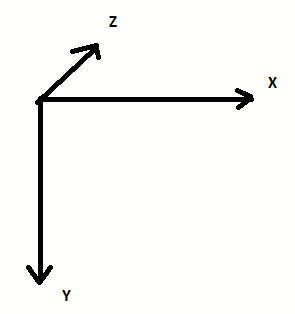

This corresponds to what COLMAP uses.

By default all functions assume the viewer is looking in the direction of Z; The direction up is -Y and the direction to the right is X. (When you're working with absolute coordinates or rotations, you're operating in this coordinate system.)

##### Warning

Geometry works refactoring it will be painful. Don't touch geometry for the time being.

# Misc

## Geometry Stuff

### Misc

In [4]:
def get_raw_view_vecs(sizex, sizey, scalingcoef = None, scalingcoefx = 1.0, scalingcoefy = 1.0):
    """
    Returns a numpy array of size [sizex, sizey, 3].
    Represents view vectors in direction of z axis.
    
    Contains vectors of the form [x, y, 1].
    x and y increase with index.
    """
    
    if scalingcoef is not None:
        scalingcoefx = scalingcoef
        scalingcoefy = scalingcoef
    
    res = np.zeros([sizex, sizey, 3], dtype = np.float32)
    compx = np.linspace(-1, 1, sizex) * scalingcoefx
    compy = np.linspace(1, -1, sizey) * sizey / sizex * scalingcoefy
    res[:, :, 0] = compx.reshape([sizex, -1])
    res[:, :, 1] = compy.reshape([-1, sizey])
    res[:, :, 2] = 1
    
    return res

def norm_view_vecs(view_vecs):
    """
    Normalizes vectors to unit vectors.
    
    Input and output are numpy arrays.
    """
    
    res = view_vecs / np.linalg.norm(view_vecs, axis = -1, keepdims = True)
    
    return res

def get_view_vecs(sizex, sizey, scalingcoef = None, scalingcoefx = 1.0, scalingcoefy = 1.0):
    vecs = get_raw_view_vecs(sizex, sizey, scalingcoef, scalingcoefx, scalingcoefy)
    vecs = norm_view_vecs(vecs)
    
    return vecs

def negate_y(data):
    """
    Assumes data is numpy array of 3D vectors of shape [d1, d2..., 3].
    Negates y coordinate sign.
    """
    
    res = data.copy()
    temp_shape = res.shape
    res = res.reshape([-1, 3])
    res[:, 1]*= -1
    res = res.reshape(temp_shape)
    
    return res

def mpl_format(data):
    """
    Reformats image from default format, to format that can be rendered by matplotlib.
    data - array [image_count, sizex, sizey, 3] or [sizex, sizey, 3] in default format.
    
    Result is in format - 
      [sizey, sizex, 3]. 
      Increase in y coordinates means "go down in image".
      
    #CoordVerified
    """
    if len(data.shape) == 3:
        return np.flip(data.swapaxes(0, 1), 0)
    elif len(data.shape) == 4:
        return np.flip(data.swapaxes(1, 2), 1)
    else:
        raise ValueError('Wrong number of dimensions passed to mpl_format ' + str(data.shape))

def mpl_format_inverse(data):
    """
    Reverses mpl_format.
    """
    if len(data.shape) == 3:
        return np.flip(data, 0).swapaxes(0, 1)
    elif len(data.shape) == 4:
        return np.flip(data, 1).swapaxes(1, 2)
    else:
        raise ValueError('Wrong number of dimensions passed to mpl_format ' + str(data.shape))
    

### Rotation Hangling

In [5]:
def rotate_vecs(rot, vecs):
    """
    Rotates an array of vectors.
    Analogous to computing np.matmul(rot, vec) for each vector.
    
    rot - np array, rotation matrix of size [3, 3].
    vecs - np array, of vectors of size [d1, d2..., 3]
    """
    tmp_shape = vecs.shape
    vecs = vecs.reshape(-1, 3).swapaxes(0, 1)
    vecs = np.matmul(rot, vecs)
    vecs = vecs.swapaxes(0, 1).reshape(tmp_shape)
    
    return vecs

class Viewer():
    """
    Represents a viewer.
    The viewer can rotate in certain directions.
    Can transform vectors between absolute and viewer reference frames.
    
    In absolute coordinates:
    Assumes x direction is to right.
    Assumes y direction is down.
    Assumes z direction is forward.
    
    In viewer reference frame:
    Assumes x direction is to right.
    Assumes y direction is down.
    Assumes z direction is forward.
    
    They're the same, don't ask questions.
    """
    
    def __init__(self):
        """
        Initializes to identity matrix.
        Initially looks in direction of z axis.
        """
        s = self
        
        s.reset()
    
    def reset(self):
        """
        Makes viewer look in direction of z axis,
        such that the viewer is up right.
        """
        s = self
        
        s.data = np.zeros([3, 3], dtype = np.float32)
        for i in range(3):
            s.data[i, i] = 1
    
    def rot_xz(self, angle):
        """
        Rotates viewer leftward.
        """
        sin = math.sin(angle)
        cos = math.cos(angle)
        rot = np.array([
            [cos, 0, sin],
            [0, 1, 0],
            [-sin, 0, cos]
        ])
        s = self
        s.data = np.matmul(s.data, rot)
    
    def rot_zy(self, angle):
        """
        Rotates viewer downward.
        """
        sin = math.sin(angle)
        cos = math.cos(angle)
        rot = np.array([
            [1, 0, 0],
            [0, cos, -sin],
            [0, sin, cos]
        ])
        s = self
        s.data = np.matmul(rot, s.data)
    
    def to_absolute(self, vecs):
        """
        Rotates numpy array of vectors from viewer reference frame to absolute reference frame.
        Assumes vecs has shape [d1, d2..., 3]
        """
        s = self
        
        shape = vecs.shape
        vecs = vecs.reshape([-1, 3])
        vecs = np.matmul(vecs, s.data)
        vecs = vecs.reshape(shape)
        
        return vecs
    
    def to_viewer(self, vecs):
        """
        Rotates numpy array of vectors from absolute reference frame to viewer reference frame.
        Assums vecs has shape [d1, d2..., 3]
        """
        s = self
        
        shape = vecs.shape
        vecs = vecs.reshape([-1, 3])
        vecs = np.matmul(vecs, np.linalg.inv(s.data))
        vecs = vecs.reshape(shape)
        
        return vecs
    
    def look_at(self, view_vec):
        """
        Rotates camera so it looks along a given view vector.
        Keeps up side up.
        """
        self.reset()
        
        view_vec = view_vec / np.linalg.norm(view_vec)
        
        x = view_vec[0]
        y = -view_vec[1]
        z = view_vec[2]
        
        #Rotate horizontally
        if x == 0 and z == 0:
            xz_angle = 0
        else:
            xz_angle = math.atan2(-x, z)
        self.rot_xz(xz_angle)

        #Rotate vertically
        horcomp = math.sqrt(x ** 2 + z ** 2)
        zy_angle = -math.atan2(y, horcomp)
        self.rot_zy(zy_angle)

## Image Handling

In [6]:
def load_image(path):
    """
    Returns numpy array in format [sizex, sizey, 3].
    """
    
    rgb = np.array(PIL.Image.open(path)) / 255.0
    rgb = mpl_format_inverse(rgb)
    return rgb

## Misc Misc

In [7]:
def beautify_number(num):
    """
    Adds tickmarks to integer.
    """
    if num == 0:
        return '0'
    
    if num < 1000:
        return str(num)
    
    res = str(num % 1000)
    num//= 1000
    while num != 0:
        while len(res) % 4 != 3:
            res = '0' + res
        res = str(num % 1000) + '\'' + res
        num//= 1000
    return res

In [8]:
def torchify(ray, requires_grad = False):
    """
    Turns numpy array into float32 pytorch tensor.
    """
    tens = torch.tensor(ray, device = def_device, dtype = torch.float32, requires_grad = requires_grad)
    return tens
    
def numpyify(tens):
    """
    Turns pytorch tensor into numpy array.
    """
    if tens.requires_grad_:
        tens = tens.detach()
    
    if torch.get_device(tens) != -1:
        tens = tens.cpu()
        
    return tens.numpy()

In [9]:
class TimeEstimator():
    """
    Class that estimates remaining time to completion.
    """
    
    def __init__(self):
        self.start = time.time()
    
    def format_time(self, seconds):
        """
        Formats amount of seconds in a nice readable way.
        """
        sleft = int(seconds)
        s = 'eta: '
        if sleft > 59:
            mleft = sleft // 60
            sleft = sleft % 60
            s+= str(mleft) + 'm '
        s+= str(sleft) + ' s'
        return s
    
    def get_estimate(self, progress, total):
        """
        progress - completed work amount.
        total - neccessary work amount.
        """
        remaining = (total - progress) / progress * (time.time() - self.start)
        return self.format_time(remaining)

# Model Parts

## Abstract Classes

In [10]:
class Model():
    """Just an abstract class, that keeps track of simple model parameters."""
    
    def __init__(self, tag = 'noname'):
        self.params = []
        self.tag = tag
    
    def weights(self, ins, outs, coefficient = 1.0):
        k = coefficient / math.sqrt(ins)
        data = np.random.uniform(-k, k, size = [ins, outs])
        tens = torch.tensor(data, requires_grad = True, device = def_device, dtype = torch.float32)
        self.params.append(tens)
        return tens

    def biases(self, outs):
        return self.zeros([outs])
    
    def zeros(self, dims):
        data = np.zeros(dims, dtype = np.float32)
        tens = torch.tensor(data, dtype = torch.float32, requires_grad = True, device = def_device)
        self.params.append(tens)
        return tens
    
    def spam(self, indent = 0):
        """
        Prints useful information about model.
        """
        class_name = str(type(self)).split('\'')[1].split('.')[1]
        self._iprint('Tag', self.tag, indent = indent)
        self._iprint('Class', class_name, indent = indent + 1)
        self._iprint('Tensor count:', len(self.params), indent = indent + 1)
        self._iprint('Param count:', beautify_number(self._get_param_count()), indent = indent + 1)
        
    def forward(self, *args, **kw):
        raise NotImplementedError()
    
    def _get_param_count(self):
        """
        Computes the current amount of trainable parameters in the model.
        """
        res = 0
        for tens in self.params:
            res+= torch.numel(tens)
        return res
    
    def _iprint(self, *args, indent = 0, **kw):
        """
        Function that works just like print function except adds an indentation
        of size indent * 2 spaces before printing.
        """
        res = ''
        for i in range(indent):
            res+= ' |'
        print(res, *args, **kw)

In [11]:
class FeatureGrid(Model):
    """
    Abstract class.
    Datastructure that returns feature vectors given coordinates.
    """
    
    def __init__(self, tag = 'FeatureGrid'):
        super().__init__(tag)
    
    def _get_rounded(self, coords):
        s = self
        
        #Rescale [-1..1] -> [0..grid_size - 1]
        coordsr = (coords + 1) / 2 * (s.grid_size - 1)
        
        #Round down
        coordsd = torch.floor(coordsr).long()
        
        return (coordsr, coordsd)
    
    def _cubic_linear_interpolate(self, rem, feats):
        """
        Assumes rem - [batch_size, 3]
        Assumes feats - [batch_size, 2, 2, 2, feat_count]
        """
        remx = rem[:, 0].reshape([-1, 1, 1, 1])
        feats_ix = feats[:, 0] * (1 - remx) + feats[:, 1] * remx
        
        remy = rem[:, 1].reshape([-1, 1, 1])
        feats_ixy = feats_ix[:, 0] * (1 - remy) + feats_ix[:, 1] * remy
        
        remz = rem[:, 2].reshape([-1, 1])
        feats_ixyz = feats_ixy[:, 0] * (1 - remz) + feats_ixy[:, 1] * remz
        
        return feats_ixyz
    
    def spam(self, indent = 0):
        super().spam(indent)
    
    def forward(self, coords):
        """
        Gets feature vectors from coordinates.
        
        Assumes coords is a tensor of size [n, 3].
        returns [n, feature_count].
        """
        raise NotImplementedError()

In [12]:
class Aggregator(FeatureGrid):
    """
    Abstract class.
    Class that aggregates together output feature vectors of multiple feature grids and returns feature vector.
    """
    
    def __init__(self, grids, tag = 'Aggregator'):
        super().__init__(tag)
        
        for grid in grids:
            self.params+= grid.params
            
        self.grids = grids
        self.grid_count = len(self.grids)
        
    def spam(self, indent = 0):
        super().spam(indent)
        self._iprint('Num. of Feature Grids: ', self.grid_count, indent = indent + 1)
        self._iprint('Grids: ', indent = indent + 1)
        for grid in self.grids:
            grid.spam(indent = indent + 2)
        
    def forward(self, coords):
        raise NotImplementedError()

In [13]:
class OpGraph(Model):
    """
    Thing that takes inputs, and returns parameters of interest.
    Performs an acyclic graph of operations using Model objects.
    """
    
    def __init__(self, operations, inputs, returnables, tag = 'OpGraph'):
        """
        Operations should be a list of dict.
        Each dict should be {'op', 'from', 'to'}.
          'op' is the thing that will do processing.
          'from' is list of labels of the data that are to be processed.
          'to' is the list of labels of the output data.
        """
        
        super().__init__(tag)
        
        s = self
        
        s.operations = operations
        s.inputs = inputs
        s.returnables = returnables
        
        for op in s.operations:
            s.params+= op['op'].params
    
    def spam(self, indent = 0):
        s = self
        
        super().spam(indent)
        self._iprint('Operation graph:', indent = indent + 1)
        for op in s.operations:
            self._iprint('Operation ' + str(op['from']) + ' -> ' + op['op'].tag + ' -> ' + str(op['to']) + '', indent = indent + 2)
            op['op'].spam(indent + 3)
    
    def forward(self, *inputs):
        s = self
        
        state = {}
        for idx, i in enumerate(inputs):
            state[s.inputs[idx]] = i
                
        for op in s.operations:
            inputs = []
            for name in op['from']:
                inputs.append(state[name])
            opres = op['op'].forward(*inputs)
            if len(op['to']) == 1:
                state[op['to'][0]] = opres
            else:
                for idx, name in enumerate(op['to']):
                    state[name] = opres[idx]
        
        res = []
        for ret in s.returnables:
            res.append(state[ret])
        
        return res

In [ ]:
class Decoder(OpGraph):
    """
    Class that represents a NeRF decoder.
    Computes pointwise rgb and density from optionally features, coordinates, view_vectors.
    """
    
    def __init__(self, operations, inputs = ['feats', 'coords', 'view_vecs'], returnables = ['rgb', 'density'], tag = 'Decoder'):
        super().__init__(operations, inputs, returnables, tag)
        
        s = self
        
    def spam(self, indent = 0):
        super().spam(indent)

In [ ]:
class NeRF(Model):
    """
    Class represents a NeRF.
    Computes rgb and density from optionally coordinates, view_vectors.
    """
    
    def __init__(self, tag = 'NeRF'):
        super().__init__(tag)
    
    def spam(self, indent = 0):
        super().spam(indent)
    
    def forward(self, coords, view_vecs):
        raise NotImplementedError()

In [ ]:
class Tracer(Model):
    """
    Abstract class.
    That does 'rgb' integration over a NeRF that retuns 'rgb' and 'density' given coordinates and view directions.
    """
    
    def __init__(self, tag = 'Tracer'):
        super().__init__(tag)
    
    def spam(self, indent = 0):
        super().spam(indent)
    
    def forward(NeRF, coords, view_vecs):
        raise notImplementedError()

In [ ]:
class Pipe(Model):
    """
    Abstract class.
    Represents a full pipeline.
    Contains a forward pass.
    Contains loss.
    """
    #@todo, rewrite so that inputs and outputs get reshaped automatically.
    
    def __init__(self, tag = 'Pipe'):
        super().__init__(tag)
        
    def spam(self, indent = 0):
        super().spam(indent)
        
    def forward(self, coords, view_vecs):
        raise notImplementedError()
    
    def loss(self, coords, view_vecs, gt_rgb):
        guess = self.forward(coords, view_vecs)
        loss = ((guess - gt_rgb) ** 2).mean()
        return loss

## Specific Parts

### Feature Grids

In [ ]:
class DenseGrid(FeatureGrid):
    """
    A 3D feature grid that uses trilinear interpolation.
    Stores features for each voxel.
    """
    
    def __init__(self, grid_size = 10, feat_count = 8, tag = 'DenseGrid'):
        super().__init__(tag)
        
        s = self
        
        s.grid_size = grid_size
        s.feat_count = feat_count
        
        s.grid = self.zeros([s.grid_size ** 3, s.feat_count])
    
    def spam(self, indent = 0):
        super().spam(indent = indent)
        self._iprint('Grid size: ', self.grid_size, indent = indent + 1)
        self._iprint('Feature count: ', beautify_number(self.feat_count), indent = indent + 1)
    
    def forward(self, coords):
        s = self
        
        cr, cd = s._get_rounded(coords)
        
        rem = cr - cd
        
        #Reshape into 1D vector for selection.
        indexes = cd[:, 0] + cd[:, 1] * s.grid_size + cd[:, 2] * s.grid_size ** 2
        indexes = indexes.abs()
        
        #Get voxels where coordinates are rounded up.
        indexes = torch.stack([indexes, indexes + 1], dim = 1) #Add voxels with ceil(x)
        indexes = torch.stack([indexes, indexes + s.grid_size], dim = 2) #Add voxels with ceil(y)
        indexes = torch.stack([indexes, indexes + s.grid_size ** 2], dim = 3) #Add voxels with ceil(z)
        indexes = torch.fmod(indexes, s.grid_size ** 3)
        
        #Get features from indexes.
        feats = torch.index_select(s.grid, dim = 0, index = indexes.reshape([-1]))
        feats = feats.reshape([-1, 2, 2, 2, s.feat_count])
        
        #Interpolate
        feats_ixyz = s._cubic_linear_interpolate(rem, feats)

        #Masking situations where we're asked to predict outside bounds.
        mask = (torch.where(coords < -1, 0, 1) * torch.where(coords >= 1, 0, 1)).prod(dim = 1)
        res = feats_ixyz * mask.reshape([-1, 1])
        
        return res

In [ ]:
class HashGrid(FeatureGrid):
    """
    A 3D feature grid that uses trilinear interpolation.
    Stores features for each voxel.
    """
    
    def __init__(self, grid_size = 10, feat_count = 8, table_size = None, primey = 19349663, primez = 83492791, tag = 'HashGrid'):
        super().__init__(tag)
        
        s = self
        
        s.grid_size = grid_size
        s.feat_count = feat_count
        
        if table_size is not None:
            s.table_size = table_size
        else:
            s.table_size = 6 * s.grid_size ** 2
        
        s.grid = self.zeros([s.table_size, s.feat_count])
    
        s.primey = primey
        s.primez = primez

    def spam(self, indent = 0):
        super().spam(indent = indent)
        self._iprint('Grid size: ', self.grid_size, indent = indent + 1)
        self._iprint('Feature count: ', beautify_number(self.feat_count), indent = indent + 1)
        self._iprint('Hash table size: ', beautify_number(self.table_size), indent = indent + 1)
        
    def forward(self, coords):
        s = self
        
        cr, cd = s._get_rounded(coords)
        
        rem = cr - cd
        
        #Multiply indexes by primes.
        indexes = cd
        indexes[:, 1]*= s.primey
        indexes[:, 2]*= s.primez
        indexes = indexes.abs()
        
        #Get voxels where coordinates are rounded up.
        indexes = torch.stack([indexes, indexes], dim = 1) #Add voxels with ceil(x)
        indexes[:, 1]+= 1
        indexes = torch.stack([indexes, indexes], dim = 2) #Add voxels with ceil(y)
        indexes[:, :, 1]+= s.primey
        indexes = torch.stack([indexes, indexes], dim = 3) #Add voxels with ceil(z)
        indexes[:, :, :, 1]+= s.primez
        indexes = torch.bitwise_xor(torch.bitwise_xor(indexes[:, :, :, :, 0], indexes[:, :, :, :, 1]), indexes[:, :, :, :, 2])
        indexes = torch.fmod(indexes, s.table_size)
        
        #Get features from indexes.
        feats = torch.index_select(s.grid, dim = 0, index = indexes.reshape([-1]))
        feats = feats.reshape([-1, 2, 2, 2, s.feat_count])
        
        #Interpolate
        feats_ixyz = s._cubic_linear_interpolate(rem, feats)

        #Masking situations where we're asked to predict outside bounds.
        mask = (torch.where(coords < -1, 0, 1) * torch.where(coords >= 1, 0, 1)).prod(dim = 1)
        res = feats_ixyz * mask.reshape([-1, 1])
        
        return res

#### Specific FeatureGrid Constructors

In [ ]:
def construct_INGP_grid(min_res = 10, 
                        max_res = 1000, 
                        levels = 8, 
                        table_size = 2 ** 14, 
                        level_feature_count = 2):
    """
    Constructs a multi-resolution hash table feature grid.
    Aggregation used is contatentation between different resolutions.
    Output should correspond to how the feature grid works in InstantNGP.
    Function takes care of the messy stuff, so you don't have to.
        
    min_res - resolution of coarsest feature grid.
    max_res - resolution of finest feature grid.
    levels - number of feature grids used.
    table_size - size of hash table per level.
    level_feature_count - number of features returned by each level.

    Function returns Aggregator object that can be used as a FeatureGrid object.

    Note:
    The defaults of this function do not correspond to what is used in INGP.
    INGP uses:
        min_res = 16
        max_res = (In paper this parameter varies between 512 and 524288)
        levels = 16
        table_size = (In paper this parameter varies between 2^14 and 2^24)
        level_feature_count = 2
    """
    
    #Calculate feature grid sizes.
    b = math.exp((math.log(max_res) - math.log(min_res)) / (levels - 1))
    grid_sizes = []
    for level in range(levels):
        grid_size = math.floor(min_res * b ** level)
        grid_sizes.append(grid_size)
    
    #Construct feature grids.
    grids = []
    for level in range(levels):
        emulated_size =  grid_sizes[level] ** 3
        if emulated_size <= table_size:
            grids.append(DenseGrid(grid_sizes[level], level_feature_count))
        else:
            grids.append(HashGrid(grid_sizes[level], level_feature_count, table_size = table_size))
    
    #Aggregate
    res = CatAggregator(grids, tag = 'INGPFeatureGrid')
    
    return res

### Aggregators

In [ ]:
class CatAggregator(Aggregator):
    """
    Concatenates output features of multiple feature grids.
    """
    def __init__(self, *args, tag = 'CatAggregator', **kw):
        super().__init__(*args, tag = tag, **kw)
    
    def spam(self, indent = 0):
        super().spam(indent)
    
    def forward(self, coords):
        res = []
        for grid in self.grids:
            res.append(grid.forward(coords))
        res = torch.cat(res, dim = 1)
        
        return res

In [ ]:
class MeanAggregator(Aggregator):
    """
    Takes the mean of the feature vectors of multiple feature grid outputs.
    """
    def __init__(self, *args, tag = 'MeanAggregator', **kw):
        """
        Requires that feature grids output the same amount of features per grid.
        """
        super().__init__(*args, tag = tag, **kw)
    
    def spam(self, indent = 0):
        super().spam(indent)
    
    def forward(self, coords):
        res = 0
        for grid in self.grids:
            res+= grid.forward(coords)
        res/= self.grid_count
        
        return res

### Decoder Parts

In [ ]:
class FCNN(Model):
    """
    A general purpouse fully connected neural network.
    """
    
    def __init__(self,
                 layer_sizes = [],
                 activations = [None, 'relu', 'relu', 'relu'],
                 tag = 'FCNN'):
        super().__init__(tag)
        
        s = self
        s.tag = 'FCNN'
        
        s.layer_count = len(layer_sizes)
        s.layer_sizes = layer_sizes.copy()
        s.activations = activations.copy()
        
        #Initializing variables
        s.w = [None]
        s.b = [None]
        for cur_layer in range(1, self.layer_count):
            prev_layer = cur_layer - 1
            s.w.append(s.weights(s.layer_sizes[prev_layer], s.layer_sizes[cur_layer]))
            s.b.append(s.biases(s.layer_sizes[cur_layer]))
        
    def spam(self, indent = 0):
        super().spam(indent)
        self._iprint('Layer sizes: ', self.layer_sizes, indent = indent + 1)
        architecture = str(self.layer_sizes[0])
        for layer in range(1, self.layer_count):
            architecture+= ' -> ' + str(self.layer_sizes[layer]) + '(' + self.activations[layer] + ')'
        self._iprint('Architecture: ', architecture, indent = indent + 1)
    
    def forward(self, *inputs):
        """
        Assumes *inputs is a list of tensors [batch_size, feats_i].
        Concatenates them along dim 1.
        """
        s = self
        
        layer = torch.cat(inputs, dim = 1)
        for cur_layer in range(1, s.layer_count):
            prev_layer = cur_layer - 1
            
            layer = torch.matmul(layer, s.w[cur_layer]) + s.b[cur_layer]
            
            activation = s.activations[cur_layer]
            if activation == 'sigmoid':
                layer = torch.sigmoid(layer)
            elif activation == 'relu':
                layer = torch.relu(layer)
            elif activation == 'none' or activation is None:
                pass
        
        return layer

In [ ]:
class SinEncoder(Model):
    """
    Object that takes in vectors of features and encodes them with sines of exponentially increasing frequency.
    """
    def __init__(self, levels = 10, base_multiplier = 1.0, exponent = 2.0, tag = 'SinEncoder'):
        super().__init__(tag)
        
        s = self
        s.tag = 'SinEnc'
        
        s.levels = levels
        s.base_multiplier = base_multiplier
        s.exponent = exponent
        
    def spam(self, indent = 0):
        super().spam(indent)
    
    def forward(self, x):
        """
        Assumes x is a tensor of size [batch_size, feats].
        Returns tensor of size [batch_size, feats * levels]
        """
        s = self
        
        mult = s.base_multiplier * s.exponent ** torch.linspace(0, s.levels - 1, s.levels, device = def_device)
        mult = mult.reshape([1, 1, -1])
        
        res = torch.sin(x.reshape([-1, x.shape[1], 1]) * mult).reshape([-1, x.shape[1] * s.levels])
        
        return res

In [ ]:
class Splitter(Model):
    """
    Literally splits a tensor of size [batch_size, n] into multiple bits.
    """
    
    def __init__(self, sizes, tag = 'Splitter'):
        super().__init__(tag)
        
        s = self
        s.tag = 'Split'
        
        s.sizes = sizes
    
    def spam(self, indent = 0):
        super().spam(indent)
    
    def forward(self, x):
        s = self
        res = []
        cum = 0
        for size in s.sizes:
            res.append(x[:, cum:cum+size])
            cum+= size
        return res

#### Specific Decoder Constructors

In [ ]:
def construct_FCNNsingle_decoder(layers = [None, 64, 64, None], 
                                 activations = [None, 'relu', 'relu', 'relu'],
                                 feat_count = 8, 
                                 feats = True, 
                                 coords = True, 
                                 view_vecs = True, 
                                 coords_sine = True, 
                                 encoding_levels = 10):
    opchain = []
    inputs = []
    input_size = 0
    if feats:
        input_size+= feat_count
        inputs.append('feats')
    
    if coords:
        if coords_sine:
            input_size+= 3 * encoding_levels
        else:
            input_size+= 3
        inputs.append('coords')
    
    if view_vecs:
        input_size+= 3
        inputs.append('view_vecs')
    
    if coords:
        if coords_sine:
            encoder = SinEncoder(levels = encoding_levels)
            opchain.append({'op': encoder, 'from': ['coords'], 'to': ['coords']})
    
    layers = layers.copy()
    layers[0] = input_size
    layers[-1] = 4
    
    decoder = FCNN(layers, activations)
    
    opchain.append({'op': decoder, 'from': inputs, 'to': ['rgba']})
    
    splitter = Splitter([3, 1])
    
    opchain.append({'op': splitter, 'from': ['rgba'], 'to': ['rgb', 'density']})
    
    return Decoder(opchain)

In [ ]:
def construct_FCNNdouble_decoder(layers = [None, 64, 64, None], 
                                 activations = [None, 'relu', 'relu', 'relu'],
                                 density_layers = [None, 64, 64, None],
                                 density_activations = [None, 'relu', 'relu', 'relu'],
                                 feat_count = 8, 
                                 feats = True, 
                                 coords = True, 
                                 view_vecs = True, 
                                 coords_sine = True, 
                                 encoding_levels = 10):
    opchain = []
    inputs = []
    input_size = 0
    if feats:
        input_size+= feat_count
        inputs.append('feats')
    
    if coords:
        if coords_sine:
            input_size+= 3 * encoding_levels
        else:
            input_size+= 3
        inputs.append('coords')
    
    if view_vecs:
        input_size+= 3
        inputs.append('view_vecs')
    
    if coords:
        if coords_sine:
            encoder = SinEncoder(levels = encoding_levels)
            opchain.append({'op': encoder, 'from': ['coords'], 'to': ['coords']})
    
    layers = layers.copy()
    layers[0] = input_size
    layers[-1] = 3
    
    rgb_decoder = FCNN(layers, activations)
    
    opchain.append({'op': rgb_decoder, 'from': inputs, 'to': ['rgb']})
    
    #Construct density decoder
    density_layers[0] = input_size
    if view_vecs:
        density_layers[0]-= 3
        inputs = inputs[:-1]
    density_layers[-1] = 1
    density_decoder = FCNN(density_layers, density_activations)
    
    opchain.append({'op': density_decoder, 'from': inputs, 'to': ['density']})
    
    return Decoder(opchain, returnables = ['rgb', 'density'])

### NeRFs

In [ ]:
class FeatureGridNeRF(NeRF):
    def __init__(self, feature_grid, decoder, tag = 'FeatureGridNeRF'):
        super().__init__(tag)
        
        s = self
        
        s.feature_grid = feature_grid
        s.decoder = decoder
        
        s.params = s.feature_grid.params + s.decoder.params
        
    def spam(self, indent = 0):
        super().spam(indent)
        self._iprint('Feature Grid: ', indent = indent + 1)
        self.feature_grid.spam(indent + 2)
        self._iprint('Decoder: ', indent = indent + 1)
        self.decoder.spam(indent + 2)
    
    def forward(self, coords, view_vecs):
        s = self
        
        features = s.feature_grid.forward(coords)
        res = s.decoder.forward(features, coords, view_vecs)
        return res

In [ ]:
class FeaturelessNeRF(NeRF):
    """
    NeRF that doesn't have a feature grid.
    """
    def __init__(self, decoder, tag = 'FeaturelessNeRF'):
        super().__init__(tag)
        
        s = self
        
        s.decoder = decoder
        
        s.params = s.decoder.params
    
    def spam(self, indent = 0):
        super().spam(indent)
        self._iprint('Decoder: ', indent = indent + 1)
        self.decoder.spam(indent + 2)
    
    def forward(self, coords, view_vecs):
        s = self
        
        res = s.decoder.forward(torch.zeros([coords.shape[0], 0], device = def_device, dtype = torch.float32), coords, view_vecs)
        return res

### Tracers

In [ ]:
class UniformTracer(Tracer):
    """
    Samples density and rgb linearly along the view vector, given a NeRF.
    """
    
    def __init__(self, stacked = True, distance = math.sqrt(3) * 2.0, steps = 32, tag = 'UniformTracer'):
        super().__init__(tag)
        
        self.distance = distance
        self.steps = steps
        
    def spam(self, indent = 0):
        super().spam(indent)
        self._iprint('Tracing distance: ', self.distance, indent = indent + 1)
        self._iprint('Tracing steps: ', self.steps, indent = indent + 1)
        
    def forward(self, coords, view_vecs, nerf):
        """
        Function that returns pixel color we see in nerf from certain location looking in a certain angle.
        
        Dimensions of coords are assumed to be [n, 3].
        Dimensions of view_vecs are assumed to be [n, 3], a tensor of unit vectors.
        nerf is assumed to be an instance of NeRF.
        distance - how far to look along the view vector.
        steps - how many samples to do along the view vector.
        
        Returns tensor [n, 3], which represents RGB values.
        """
        
        s = self
        
        #This code may look odd because I'm trying to stack all steps into a single nerf run.
        #It would look more intuitive if it were written less optimally.
        
        #Calculating view vectors that will be passed to nerf
        view_vecs = view_vecs.reshape([-1, 1, 3])
        tmp_view_vecs = view_vecs #This is a quick and dirty bugfix.
        view_vecs = torch.broadcast_to(view_vecs, [view_vecs.shape[0], s.steps, 3])
        view_vecs = view_vecs.reshape([-1, 3])
        
        #calculating cooredinates that will be passed to nerf.
        step_size = s.distance / s.steps
        view_vec_step = tmp_view_vecs * step_size
        
        step_nums = [i + 1 for i in range(s.steps)]
        step_nums = torch.tensor(step_nums, device = def_device, dtype = torch.float32, requires_grad = False)
        step_nums = step_nums.reshape([1, s.steps, 1])

        sample_coords = coords.reshape([-1, 1, 3])
        sample_coords = sample_coords + view_vec_step * step_nums
        sample_coords = sample_coords.reshape([-1, 3])
        
        #Running nerf.
        rgb, density = nerf.forward(sample_coords, view_vecs)

        rgb = rgb.reshape([-1, s.steps, 3])
        density = density.reshape([-1, s.steps])

        density = density * step_size
        
        cum_density = torch.cumsum(density, dim = 1)
        visibility = torch.exp(-cum_density)
        pad = torch.ones([visibility.shape[0], 1], dtype = torch.float32, device = def_device, requires_grad = False)
        visibility = torch.cat([pad, visibility], dim = 1)
        visibility = visibility[:, :-1] - visibility[:, 1:]
        
        result = (rgb * visibility.reshape([-1, s.steps, 1])).sum(dim = 1)
        
        return result

In [ ]:
class UniformRandomTracer(Tracer):
    """
    Samples density and rgb linearly along the view vector, given a NeRF.
    """
    
    def __init__(self, stacked = True, distance = math.sqrt(3) * 2.0, steps = 32, tag = 'UniformRandomTracer'):
        super().__init__(tag)
        
        self.distance = distance
        self.steps = steps
        
    def spam(self, indent = 0):
        super().spam(indent)
        self._iprint('Tracing distance: ', self.distance, indent = indent + 1)
        self._iprint('Tracing steps: ', self.steps, indent = indent + 1)
        
    def forward(self, coords, view_vecs, nerf):
        """
        Function that returns pixel color we see in nerf from certain location looking in a certain angle.
        
        Dimensions of coords are assumed to be [n, 3].
        Dimensions of view_vecs are assumed to be [n, 3], a tensor of unit vectors.
        nerf is assumed to be an instance of NeRF.
        distance - how far to look along the view vector.
        steps - how many samples to do along the view vector.
        
        Returns tensor [n, 3], which represents RGB values.
        """
        
        s = self
        
        #This code may look odd because I'm trying to stack all steps into a single nerf run.
        #It would look more intuitive if it were written less optimally.
        
        #Calculating view vectors that will be passed to nerf
        view_vecs = view_vecs.reshape([-1, 1, 3])
        tmp_view_vecs = view_vecs #This is a quick and dirty bugfix.
        view_vecs = torch.broadcast_to(view_vecs, [view_vecs.shape[0], s.steps, 3])
        view_vecs = view_vecs.reshape([-1, 3])
        
        #calculating cooredinates that will be passed to nerf.
        step_size = s.distance / s.steps
        view_vec_step = tmp_view_vecs * step_size
        
        step_nums = [i + 1 for i in range(s.steps)]
        step_nums = torch.tensor(step_nums, device = def_device, dtype = torch.float32, requires_grad = False)
        step_nums = step_nums.reshape([1, s.steps, 1])
        step_nums = step_nums - torch.rand(*step_nums.shape, device = def_device, dtype = torch.float32)

        sample_coords = coords.reshape([-1, 1, 3])
        sample_coords = sample_coords + view_vec_step * step_nums
        sample_coords = sample_coords.reshape([-1, 3])
        
        #Running nerf.
        rgb, density = nerf.forward(sample_coords, view_vecs)

        rgb = rgb.reshape([-1, s.steps, 3])
        density = density.reshape([-1, s.steps])

        density = density * step_size
        
        cum_density = torch.cumsum(density, dim = 1)
        visibility = torch.exp(-cum_density)
        pad = torch.ones([visibility.shape[0], 1], dtype = torch.float32, device = def_device, requires_grad = False)
        visibility = torch.cat([pad, visibility], dim = 1)
        visibility = visibility[:, :-1] - visibility[:, 1:]
        
        result = (rgb * visibility.reshape([-1, s.steps, 1])).sum(dim = 1)
        
        return result

### Pipes

In [ ]:
class SimplePipe(Pipe):
    """
    Just the standard pipeline.
    A NeRF + tracer.
    """
    
    def __init__(self, nerf, tracer):
        super().__init__()
        
        s = self
        
        s.nerf = nerf
        s.tracer = tracer
        
        s.params = s.nerf.params
    
    def spam(self, indent = 0):
        super().spam(indent)
        
        s = self
        
        s._iprint('NeRF: ', indent = indent + 1)
        s.nerf.spam(indent + 2)
        s._iprint('Tracer: ', indent = indent + 1)
        s.tracer.spam(indent + 2)
        
    def forward(self, coords, view_vecs, batch_size = None):
        s = self
        if batch_size is None:
            guess = s.tracer.forward(coords, view_vecs, s.nerf)
        else:
            res = []
            offset = 0
            while offset < coords.shape[0]:
                coord_slice = coords[offset:offset + batch_size]
                view_vec_slice = view_vecs[offset: offset + batch_size]
                res.append(s.tracer.forward(coord_slice, view_vec_slice, s.nerf))
                offset+= batch_size
            guess = torch.cat(res, dim = 0)
        return guess

# Datasets

## Abstract Classes

In [ ]:
class Image():
    """
    Class that represents an image and it's relevant parameters.
    """
    def __init__(self, coord, rot, rgb, fov, aberrations = {}, misc = {}):
        self.coord = coord.copy()
        
        self.rot = rot.copy()
        
        self.rgb = rgb.copy() #Represents rgb relating to image.
        self.sizex = self.rgb.shape[0]
        self.sizey = self.rgb.shape[1]
        self.pix_count = self.sizex * self.sizey
        
        self.fov = fov
        
        unit = np.array([0, 0, 1], dtype = np.float32)
        self.forward = np.matmul(self.rot, unit) #Stores forward direction of image.
        
        self.aberrations = aberrations
        
        self.misc = misc
    
    def get_view_vecs(self):
        """
        Returns view vectors of image.
        """
        vecs = get_view_vecs(self.sizex, self.sizey, self.fov)
        vecs = rotate_vecs(self.rot, vecs)
        return vecs
    
    def downscale(self, factor = 2):
        """
        Downsamples image.
        Mucks around with image parameters so that they're still legit.
        """
        self.rgb = self.rgb[::factor, ::factor]
        self.sizex = self.rgb.shape[0]
        self.sizey = self.rgb.shape[1]
        self.pix_count = self.sizex * self.sizey
    
    def show_image(self):
        plt.imshow(mpl_format(self.rgb))
    
    def spam(self):
        print('Image')
        
        print('Size: ', self.sizex, 'x', self.sizey, '[', self.pix_count, ']')
        
        print('Coordinates:', self.coord)
        
        print('Rotation Matrix:')
        print(self.rot)
        
        print('Forward Vector:', self.forwards)
        
        print('Aberrations: ', self.aberrations)
        
        print('Misc information: ', self.misc)
        
def norm_image_coords(images):
    """
    Normalizes image coordinates, so that hopefully everything would fit into a [-1..1]^3 cube.
    """
    
    coords = []
    for image in images:
        coords.append(image.coord)
    coords = np.array(coords)
    mean = coords.mean(axis = 0)
    for image in images:
        image.coord-= mean
        image.coord/= 8

In [ ]:
class Dataset(Model):
    """
    Abstract class for object that gives samples of camera positions, view vectors and ground truth rgb.
    
    #CoordVerified
    """
    
    def __init__(self, images = None, tag = 'Dataset'):
        """
        Assumes image - list of Image objects.
        """
        super().__init__(tag)
        
        self.image_count = len(images)
        
        self.images = images
        
        self.pix_count = 0
        for image in self.images:
            self.pix_count+= image.pix_count
    
    def sample(self, batch_size = None):
        """
        Function returns tuple of (coords, view_vecs, rgb)
        """
        raise NotImplementedError()
        
    def reset(self):
        """
        Function that resets batch sampling.
        """
        raise NotImplementedError()
    
    def permute(lists, seed = None):
        """
        Function that permutes list of tensors of size [[n, d1], [n, d2], [n, d3]...].
        Returns list of permuted tensors.
        """
        #Data verification
        element_count = lists[0].shape[0]
        for ls in lists:
            if ls.shape[0] != element_count:
                raise ValueError('Dimension 0 of tensors are different. Cannot permute.')
        
        #Permute
        if seed is not None:
            np.random.seed(seed)
        permutation = torch.tensor(np.random.permutation(element_count), 
                                   dtype = torch.long, 
                                   requires_grad = False, 
                                   device = def_device)
        res = []
        for ls in lists:
            res.append(torch.index_select(ls, 0, permutation))
        
        return res
    
    def loss(s):
        """
        Function that returns Dataset loss if it has trainable parameters.
        """
        return 0
    
    def _coord_vec_rgb_constructor(s, images):
        """
        The operation of getting coords, view_vecs and rgb, tensors seems to recur,
        so I'm making a function for it.
        """
        s.coords = []
        for image in images:
            s.coords.append(image.coord)
        s.coords = np.array(s.coords)
        s.coords = torchify(s.coords)
        
        s.view_vecs = []
        for image in images:
            s.view_vecs.append(image.get_view_vecs())
        s.view_vecs = np.array(s.view_vecs)
        s.view_vecs = torchify(s.view_vecs)
        
        s.rgb = []
        for image in images:
            s.rgb.append(image.rgb)
        s.rgb = np.array(s.rgb)
        s.rgb = torchify(s.rgb)
        
        #Broadcast coords
        s.coords = torch.broadcast_to(s.coords.reshape([-1, 1, 1, 3]), s.view_vecs.shape)
        
        #Reshape to vector of vectors.
        s.coords = s.coords.reshape([-1, 3])
        s.view_vecs = s.view_vecs.reshape([-1, 3])
        s.rgb = s.rgb.reshape([-1, 3])
    
    def spam(self, indent = 0):
        super().spam(indent)
        self._iprint('Image count: ', self.image_count, indent = indent + 1)
        self._iprint('Pixel Count: ', beautify_number(self.pix_count), indent = indent + 1)
    
    def show_images(self, amt = -1):
        if amt == -1:
            amt = self.image_count
        
        sidelen = math.ceil(math.sqrt(amt))
        plt.figure(figsize = (12, 12))
        for img in range(self.image_count):
            plt.subplot(sidelen, sidelen, img + 1)
            plt.imshow(mpl_format(self.images[img].rgb))
            plt.title(str(img))

## Dataset Classes

In [ ]:
class StaticDataset(Dataset):
    """
    Class represents just a regular dataset of images.
    View vectors, coords and rgb do not change during training.
    
    #CoordVerified
    """
    
    def __init__(s, images, tag = 'StaticDataset'):
        """
        Assumes images - list of Image object.
        Assumes camera - Camera object.
        """
        super().__init__(images, tag)
        
        s._coord_vec_rgb_constructor(images)
        
        #Permute dataset
        s.coords, s.view_vecs, s.rgb = Dataset.permute([s.coords, s.view_vecs, s.rgb])
        
        #Initialize offset
        s.reset()

    def sample(self, batch_size = 2048):
        s = self
        
        ifrom = self.offset
        ito = (self.offset + batch_size) % s.pix_count
        
        if self.offset + batch_size < s.pix_count:
            coords = s.coords[ifrom: ito]
            view_vecs = s.view_vecs[ifrom: ito]
            rgb = s.rgb[ifrom: ito]
        else:
            coords = torch.cat([s.coords[ifrom:], s.coords[:ito]], dim = 0)
            view_vecs = torch.cat([s.view_vecs[ifrom:], s.view_vecs[:ito]], dim = 0)
            rgb = torch.cat([s.rgb[ifrom:], s.rgb[:ito]], dim = 0)
            
        self.offset+= batch_size
        self.offset%= s.pix_count
        
        return (coords, view_vecs, rgb)
        
    def reset(self):
        s = self
        
        s.offset = 0

In [ ]:
class MorphingDataset(Dataset):
    """
    Dataset that contains some learnable camera or image parameters.
    Takes colmap output as base to train on.
    
    Learnable parameters:
        learn_radial - Whether to adjust scaling of image.
        learn_position - Whether to adjust camera positions.
        learn_xfov - Whether to adjust camera x scaling.
        learn_yfoc - Whether to adjust camera y scaling.
        learn_angle - Whether to adjust camera angle.
    All default to False.
    
    L2 loss coefficeints:
        l2_radialfov,
        l2_position,
        l2_xfov,
        l2_yfov,
        l2_angle
    All default to 0.01.
        
    radial, xfov, yfov are considered to be the same for all images.
    position and angle are adjusted seperately for each image.
    """

    def __init__(self,
                 images,
                 learn_radialfov = False,
                 learn_position = False,
                 learn_xfov = False,
                 learn_yfov = False,
                 learn_angle = False,
                 l2_radialfov = 1e-2,
                 l2_position = 1e-2,
                 l2_xfov = 1e-2,
                 l2_yfov = 1e-2,
                 l2_angle = 1e-2,
                 tag = 'MorphingDataset'):
        """
        Assumes images is list of Image object.
        """
        super().__init__(images, tag)
        
        s = self

        s.images = images
        
        s._coord_vec_rgb_constructor(s.images)
        
        s.view_vecs = None
        
        #Create view vector components for scaling purpouses.
        s.xcomp = []
        s.ycomp = []
        s.zcomp = []
        for image in s.images:
            xcomp = np.zeros([image.sizex, image.sizey, 3], dtype = np.float32)
            xcomp[:, :, 0] = (np.linspace(-1, 1, image.sizex) * image.fov).reshape([image.sizex, 1])
            xcomp = rotate_vecs(image.rot, xcomp)
            s.xcomp.append(xcomp)
            
            ycomp = np.zeros([image.sizex, image.sizey, 3], dtype = np.float32)
            ycomp[:, :, 1] = (np.linspace(1, -1, image.sizey) * image.fov / image.sizex * image.sizey).reshape([1, image.sizey])
            ycomp = rotate_vecs(image.rot, ycomp)
            s.ycomp.append(ycomp)
            
            zcomp = np.zeros([image.sizex, image.sizey, 3], dtype = np.float32)
            zcomp[:, :, 2] = 1
            zcomp = rotate_vecs(image.rot, zcomp)
            s.zcomp.append(zcomp)
        s.xcomp = np.array(s.xcomp)
        s.xcomp = torchify(s.xcomp)
        s.ycomp = np.array(s.ycomp)
        s.ycomp = torchify(s.ycomp)
        s.zcomp = np.array(s.zcomp)
        s.zcomp = torchify(s.zcomp)
        
        s.coords = s.coords.reshape([-1, 3])
        s.rgb = s.rgb.reshape([-1, 3])
        s.xcomp = s.xcomp.reshape([-1, 3])
        s.ycomp = s.ycomp.reshape([-1, 3])
        s.zcomp = s.zcomp.reshape([-1, 3])
        
        s.coords = Dataset.permute([s.coords], seed = 42)[0]
        s.rgb = Dataset.permute([s.rgb], seed = 42)[0]
        s.xcomp = Dataset.permute([s.xcomp], seed = 42)[0]
        s.ycomp = Dataset.permute([s.ycomp], seed = 42)[0]
        s.zcomp = Dataset.permute([s.zcomp], seed = 42)[0]
        
        #Prep for learning radial fov.
        s.learn_radialfov = learn_radialfov
        if s.learn_radialfov:
            s.l2_radialfov = l2_radialfov
            s.radial_adjustment = torchify(1.0, requires_grad = True)
            s.params.append(s.radial_adjustment)
        
        #Prep for learning camera positions.
        s.learn_position = learn_position
        if s.learn_position:
            s.l2_position = l2_position
            data = np.zeros([s.image_count, 3], dtype = np.float32)
            s.position_adjustments = torchify(data, requires_grad = True)
            s.params.append(s.position_adjustments)
            
        #Prep for component-wise fov adjustment.
        s.learn_xfov = learn_xfov
        if s.learn_xfov:
            s.l2_xfov = l2_xfov
            s.xfov_adjustment = torchify(1.0, requires_grad = True)
            s.params.append(s.xfov_adjustment)
        
        s.learn_yfov = learn_yfov
        if s.learn_yfov:
            s.l2_yfov = l2_yfov
            s.yfov_adjustment = torchify(1.0, requires_grad = True)
            s.params.append(s.yfov_adjustment)
        
        #As of now these are not implemented:
        #Prep for angle adjustment.
        #Like no idea how I can actually implement this.
        #I guess for small aberations I can model this as yaw, pitch and roll.
        s.learn_angle = learn_angle
        if s.learn_angle:
            s.l2_angle = l2_angle
            
            s.yaw = torchify(np.zeros([s.image_count]), requires_grad = True)
            s.pitch = torchify(np.zeros([s.image_count]), requires_grad = True)
            s.roll = torchify(np.zeros([s.image_count]), requires_grad = True)
            
            s.params.append(s.yaw)
            s.params.append(s.pitch)
            s.params.append(s.roll)
            
            rots = np.zeros([s.image_count, 3, 3], np.float32)
            rots[:, 0, 0] = 1
            rots[:, 1, 1] = 1
            rots[:, 2, 2] = 1
            s.unit_matrixes = torchify(rots)

        if s.learn_position or s.learn_angle:
            data = np.zeros([s.image_count, s.images[0].sizex, s.images[0].sizey], dtype = np.int32)
            for i in range(s.image_count):
                data[i] = i

            s.position_adjustment_idx = torch.tensor(data, dtype = torch.long, device = def_device)
            s.position_adjustment_idx = s.position_adjustment_idx.reshape([-1])
            s.position_adjustment_idx = Dataset.permute([s.position_adjustment_idx], seed = 42)[0]

    def sample_slice(s, ifrom, ito):
        coords = s.coords[ifrom:ito]
        
        if s.learn_position:
            nudge_idx = s.position_adjustment_idx[ifrom:ito]
            nudges = torch.index_select(s.position_adjustments, 0, nudge_idx)
            coords = coords + nudges
        
        rgb = s.rgb[ifrom:ito]
        
        xcomp = s.xcomp[ifrom:ito]
        ycomp = s.ycomp[ifrom:ito]
        zcomp = s.zcomp[ifrom:ito]
        
        if s.learn_radialfov:
            xcomp = xcomp * s.radial_adjustment
            ycomp = ycomp * s.radial_adjustment
        
        if s.learn_xfov:
            xcomp = xcomp * s.xfov_adjustment
        
        if s.learn_yfov:
            ycomp = ycomp * s.yfov_adjustment
        
        #Modeling radial adjustment.
        view_vecs = xcomp + ycomp + zcomp
        view_vecs = view_vecs / torch.norm(view_vecs, dim = 1).reshape([-1, 1])
        
        if s.learn_angle:
            #Disclaimer, I think this probably is a reasonable way to model aberations in angle,
            #but I'm not certain.
            
            #Compute rotation matrices for each image.
            sin = torch.sin(s.yaw)
            cos = torch.cos(s.yaw)
            mtxy = torch.zeros([s.image_count, 3, 3], dtype = torch.float32, requires_grad = False, device = def_device)
            mtxy[:, 0, 0] = 1
            mtxy[:, 1, 1] = cos
            mtxy[:, 2, 2] = cos
            mtxy[:, 1, 2] = -sin
            mtxy[:, 2, 1] = sin

            sin = torch.sin(s.pitch)
            cos = torch.cos(s.pitch)
            mtxp = torch.zeros([s.image_count, 3, 3], dtype = torch.float32, requires_grad = False, device = def_device)
            mtxp[:, 1, 1] = 1
            mtxp[:, 0, 0] = cos
            mtxp[:, 2, 2] = cos
            mtxp[:, 0, 2] = -sin
            mtxp[:, 2, 0] = sin

            sin = torch.sin(s.roll)
            cos = torch.cos(s.roll)
            mtxr = torch.zeros([s.image_count, 3, 3], dtype = torch.float32, requires_grad = False, device = def_device)
            mtxr[:, 2, 2] = 1
            mtxr[:, 1, 1] = cos
            mtxr[:, 0, 0] = cos
            mtxr[:, 1, 0] = -sin
            mtxr[:, 0, 1] = sin
            
            mtx = torch.matmul(torch.matmul(mtxp, mtxy), mtxr)
            
            #Select rotation matrices
            nudge_idx = s.position_adjustment_idx[ifrom:ito] #I probably need to rename this variable.
            mtxes = torch.index_select(mtx, 0, nudge_idx)
            
            #Rotate view vectors
            view_vecs = torch.matmul(mtxes, view_vecs.reshape(-1, view_vecs.shape[1], 1))[:, :, 0]
        
        return (coords, view_vecs, rgb)
        
    def sample(self, batch_size = 2048):
        s = self
        
        ifrom = self.offset
        ito = (self.offset + batch_size) % s.pix_count
        
        if self.offset + batch_size <= s.pix_count:
            coords, view_vecs, rgb = self.sample_slice(ifrom, ito)
        else:
            coords1, view_vecs1, rgb1 = self.sample_slice(ifrom, s.pix_count)
            coords2, view_vecs2, rgb2 = self.sample_slice(0, ito)
            
            coords = torch.cat([coords1, coords2], dim = 0)
            view_vecs = torch.cat([view_vecs1, view_vecs2], dim = 0)
            rgb = torch.cat([rgb1, rgb2], dim = 0)
            
        self.offset+= batch_size
        self.offset%= s.pix_count
        
        return (coords, view_vecs, rgb)
        
    def _radial_loss(s):
        return (s.radial_adjustment - 1) ** 2 * s.l2_radialfov
        
    def _position_loss(s):
        return (s.position_adjustments ** 2).sum() * s.l2_position
        
    def _xfov_loss(s):
        return (s.xfov_adjustment - 1) ** 2 * s.l2_xfov
    
    def _yfov_loss(s):
        return (s.yfov_adjustment - 1) ** 2 * s.l2_yfov
        
    def _angle_loss(s):
        return (s.yaw ** 2 + s.pitch ** 2 + s.roll ** 2).sum() * s.l2_angle
        
    def loss(s):
        """
        Loss of dataset adjustments.
        """
        res = 0
        if s.learn_radialfov:
            res+= s._radial_loss()
        
        if s.learn_position:
            res+= s._position_loss()
        
        if s.learn_xfov:
            res+= s._xfov_loss()
        
        if s.learn_yfov:
            res+= s._yfov_loss()

        if s.learn_angle:
            res+= s._angle_loss()

        return res
        
    def spam(s, indent = 0):
        super().spam(indent)
        if s.learn_radialfov:
            s._iprint('Radial FOV Adjustment', indent = indent + 1)
            s._iprint('Radial FOV Adjustment: ', s.radial_adjustment, indent = indent + 2)
            s._iprint('Radial L2 coef: ', s.l2_radialfov, indent = indent + 2)
            s._iprint('Radial Loss: ', s._radial_loss(), indent = indent + 2)
            
        if s.learn_position:
            s._iprint('Positions Adjustment', indent = indent + 1)
            s._iprint('Average Position Adjustment: ', s.position_adjustments.abs().mean(), indent = indent + 2)
            s._iprint('Position L2 coef: ', s.l2_position, indent = indent + 2)
            s._iprint('Position Loss: ', s._position_loss(), indent = indent + 2)
            
        if s.learn_xfov:
            s._iprint('XFOV Adjustment', indent = indent + 1)
            s._iprint('XFOV Adjustment: ', s.xfov_adjustment, indent = indent + 2)
            s._iprint('XFOV L2 coef: ', s.l2_xfov, indent = indent + 2)
            s._iprint('XFOV Loss: ', s._xfov_loss(), indent = indent + 2)
            
        if s.learn_yfov:
            s._iprint('YFOV Adjustment', indent = indent + 1)
            s._iprint('YFOV Adjustment: ', s.yfov_adjustment, indent = indent + 2)
            s._iprint('YFOV L2 coef: ', s.l2_yfov, indent = indent + 2)
            s._iprint('YFOV Loss: ', s._yfov_loss(), indent = indent + 2)

        if s.learn_angle:
            s._iprint('Angle Adjustment', indent = indent + 1)
            s._iprint('Average angle adjustment: ', s.yaw.abs().mean() + s.pitch.abs().mean() + s.roll.abs().mean(), indent = indent + 2)
            s._iprint('Angle L2 coef: ', s.l2_angle, indent = indent + 2)
            s._iprint('Angle Loss: ', s._angle_loss(), indent = indent + 2)

        s._iprint('Cumulative Loss: ', s.loss(), indent = indent + 1)
             
    def reset(self):
        s = self
        
        s.offset = 0

## Getting Synthetic datasets (This doesn't work currently)

### Rendering

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

x_size = 64
y_size = 64

depth_buffer = np.zeros([x_size, y_size], dtype = np.float32) + 100000
color_buffer = np.zeros([x_size, y_size, 3], dtype = np.float32)

#CoordVerified

camera_pos = np.zeros([3], dtype = np.float32)
hor_angle = 0.0 #Angles turn camera counterclockwise.
ver_angle = 0.0 #Positive angles turn camera down.
#Angles in radians.
pov_coef = 1.0 #Assumes this to be true for x and scales y analogously.

#CoordVerified

def reset_camera():
    global camera_rot
    camera_rot = np.zeros([3, 3], dtype = np.float32)
    for i in range(3):
        camera_rot[i, i] = 1

reset_camera()

def rot_xz(angle):
    global camera_rot
    #Turns camera counterclockwise.
    rot = np.zeros([3, 3], dtype = np.float32)

    rot[1, 1] = 1
    rot[0, 0] = math.cos(angle)
    rot[0, 2] = -math.sin(angle)
    rot[2, 0] = math.sin(angle)
    rot[2, 2] = math.cos(angle)

    camera_rot = np.matmul(camera_rot, rot)

    #CoordVerified.
    
def rot_yz(angle):
    global camera_rot
    #Turns camera downward.
    rot = np.zeros([3, 3], dtype = np.float32)

    rot[0, 0] = 1
    rot[1, 1] = math.cos(angle)
    rot[1, 2] = math.sin(angle)
    rot[2, 1] = - math.sin(angle)
    rot[2, 2] = math.cos(angle)

    camera_rot = np.matmul(camera_rot, rot)
    
    #CoordVerified.

def render_pix(pixpos, col = np.array([1.0, 1.0, 1.0], dtype = np.float32)):
    global depth_buffer
    global color_buffer
    relpos = pixpos - camera_pos
    relpos = np.matmul(relpos, camera_rot)
    if relpos[2] <= 0:
        return

    scrpos = relpos.copy()
    scrpos[0]/= relpos[2] / x_size / pov_coef
    scrpos[1]/= relpos[2] / x_size / pov_coef
    scrpos[0]+= x_size / 2.0
    scrpos[1]*= -1
    scrpos[1]+= y_size / 2.0

    cx = math.floor(scrpos[0])
    cy = math.floor(scrpos[1])

    if cx < 0 or cy < 0:
        return
    if cx >= x_size or cy >= y_size:
        return
    if depth_buffer[cx, cy] > scrpos[2]:
        depth_buffer[cx, cy] = scrpos[2]
        color_buffer[cx, cy] = col
        
    #CoordVerified

def render_pg(offset, v, u, vpoints = 100, upoints = 100, col = np.array([1.0, 1.0, 1.0], dtype = np.float32)):
    vstep = v / (vpoints - 1)
    ustep = u / (upoints - 1)
    for vpoint in range(vpoints):
        for upoint in range(upoints):
            curpos = offset + vstep * vpoint + ustep * upoint
            render_pix(curpos, col)
    return

def gen_view_vecs():
    vecs = np.zeros([x_size, y_size, 3], dtype = np.float32)
    for x in range(x_size):
        for y in range(y_size):
            vec = np.array([(x - x_size / 2) / x_size * pov_coef, -(y - y_size / 2) / x_size * pov_coef, 1], dtype = np.float32)
            vecs[x, y] = vec / np.linalg.norm(vec)
    vecs = np.matmul(vecs, np.linalg.inv(camera_rot))
    return vecs

    #CoordVerified

def render_box(c1, c2):
    xvec = np.array([c2[0] - c1[0], 0, 0])
    yvec = np.array([0, c2[1] - c1[1], 0])
    zvec = np.array([0, 0, c2[2] - c1[2]])
    render_pg(c1, xvec, yvec, col = np.array([0.5, 0.7, 0.9]))
    render_pg(c1, xvec, zvec, col = np.array([0.7, 0.5, 0.9]))
    render_pg(c1, yvec, zvec, col = np.array([0.5, 0.9, 0.7]))
    render_pg(c1 + yvec, xvec, zvec, col = np.array([0.7, 0.9, 0.5]))
    render_pg(c1 + xvec, yvec, zvec, col = np.array([0.9, 0.5, 0.7]))
    render_pg(c1 + zvec, xvec, yvec, col = np.array([0.9, 0.7, 0.5]))
    
def render_box_rel(c1, sizes):
    render_box(c1, c1 + sizes)

def vec(x, y, z):
    return np.array([x, y, z])

def cvp():
    global color_buffer
    global depth_buffer
    color_buffer*= 0
    #color_buffer+= 0.5
    depth_buffer[:, :] = 1000000
    reset_camera()

def draw():
    plt.figure()
    tmp = np.flip(color_buffer.swapaxes(0, 1), 0)
    plt.imshow(tmp)
    
    #CoordVerified

### Dataset Generation

In [ ]:
img_data = []
vec_data = []
positions = []

ang_c = 0
for i in range(ang_c):
    cvp()
    angle = math.pi * i / ang_c * 2
    pos = vec(math.sin(angle), -0.5, -math.cos(angle)) / 2
    camera_pos = pos
    rot_xz(angle)
    rot_yz(0.4)
    render_box_rel(vec(-0.25, -0.25, -0.25) / 2, vec(0.5, 0.5, 0.5)/ 2)
    img_data.append(color_buffer.copy())
    vec_data.append(gen_view_vecs())
    positions.append(pos)
    
    #CoordVerified

img_data = np.array(img_data)
vec_data = np.array(vec_data)
positions = np.array(positions)
#DATASET_CUBE = StaticDataset(positions, vec_data, img_data)

In [ ]:
#DATASET_CUBE.show_images()

## Getting Real Datasets

In [ ]:
import os

def get_colmap_cameras(path):
    """
    Tries to decode colmap camera parameters.
    Assumes the colmap output will contain exactly one camera.
    Assumes the camera has colmap type SIMPLE_RADIAL.
    
    path - path to file cameras.txt
    
    Returns dictionary that contains camera description.
    
    #CoordVerified
    """
    
    file = open(path, 'r')
    lines = file.readlines()
    file.close()
    
    for line in lines:
        #Skip comment lines
        if line[0] == '#':
            continue

        res = {}

        parameters = line.split(' ')
        
        if parameters[1] != 'SIMPLE_RADIAL':
            raise ValueError('Colmap file ' + path + ' is type ' + parameters[1] + '; expected SIMPLE_RADIAL.')
        
        #Image size
        res['sizex'] = int(parameters[2])
        res['sizey'] = int(parameters[3])
        
        #Focal length in pixels.
        #Connected to camera angle width.
        res['fl'] = float(parameters[4])
        res['scalingcoef'] = res['sizex'] / res['fl'] / 2
        
        #I think this is somehow related to the camera camera center offset.
        res['cx'] = float(parameters[5])
        res['cy'] = float(parameters[6])
        
        #Literally no clue what this is.
        res['???'] = float(parameters[7])
        
        break
    
    return [res]

def get_colmap_images(path):
    """
    Tries to decode colmap image parameters.
    Assumes there's exactly one camera
    
    Returns list of dictionaries describing images.
    
    path - path to images.txt file.
    
    #CoordVerified
    """
    
    file = open(path, 'r')
    lines = file.readlines()
    file.close()
    
    images = []
    
    for line in lines:
        #Skip comments.
        if line[0] == '#':
            continue
            
        params = line.split(' ')
        #Skip image feature lines
        if len(params) > 30:
            continue
            
        image = {}
        
        #Image ID
        image['ID'] = int(params[0])
        
        #Rotation quaternion
        qr = float(params[1])
        qi = float(params[2])
        qj = float(params[3])
        qk = float(params[4])
        image['QR'] = qr
        image['QX'] = qi
        image['QY'] = qj
        image['QZ'] = qk
        
        #Get rotation matrix.
        rot = [[1-2*(qj**2 + qk**2), 2*(qi*qj - qk*qr), 2*(qi*qk + qj*qr)],
               [2*(qi*qj + qk*qr), 1-2*(qi**2 + qk**2), 2*(qj*qk - qi*qr)],
               [2*(qi*qk - qj*qr), 2*(qj*qk + qi*qr), 1-2*(qi**2 + qj**2)]]
        rot = np.array(rot)
        rot = rot.transpose()
        
        #Rotation matrix such that np.matmul(rot, [x, y, z]) moves coordinates from viewer's rotation reference frame to absolute
        #rotation reference frame.
        image['rot'] = np.array(rot)
        
        #Image transposition
        tx = float(params[5])
        ty = float(params[6])
        tz = float(params[7])
        image['TX'] = tx
        image['TY'] = ty
        image['TZ'] = tz
        
        if params[8] != '1':
            raise ValueError('Expected file ' + path + ' to contain one camera, but contains more.')
            
        #Absolute coordinates of camera.
        image['coord'] = -np.matmul(rot, np.array([image['TX'], image['TY'], image['TZ']]))
        
        image['filename'] = params[-1][:-1]
        
        images.append(image)
    
    return images

def construct_images_from_colmap(path, image_path = None, downscale = 1):
    """
    Constructs list of Image objects from colmap outputs.
    
    path - folder containing images.txt and cameras.txt.
    image_path - folder containing images.
    """
    
    if image_path is None:
        image_path = path + '/Images'
    
    colmap_images = get_colmap_images(path + '/images.txt')
    colmap_cameras = get_colmap_cameras(path + '/cameras.txt')
    
    res = []
    for image in colmap_images:
        rgb = load_image(image_path + '/' + image['filename'])
        new_img = Image(coord = image['coord'], 
                        rot = image['rot'],
                        fov = colmap_cameras[0]['scalingcoef'],
                        rgb = rgb,
                        misc = {'filename': image['filename']})
        res.append(new_img)
        res[-1].downscale(downscale)
    
    return res

def quick_colmap_images(name, downscale = 2):
    """
    Function that fetches a specific dataset just given the dataset name.
    Uses the fact that I know where exactly the files are and in what format.
    
    Returns list of Image objects.
    
    It's likely this function will be deprecated in the future.
    """
    
    res = construct_images_from_colmap('Datasets/' + name, downscale = downscale)
    norm_image_coords(res)
    
    return res

# Training

In [ ]:
def train(pipe, dataset, batch_count = 1000, batch_size = 2048, spam_frequency = 100, lr = 0.001, lr_dataset = 0.00001, dataset_loss_start = 0):
    """
    Function that trains pipeline on some dataset.
    """
    
    optim = torch.optim.Adam(pipe.params, lr = lr)
    if len(dataset.params) != 0:
        optim2 = torch.optim.Adam(dataset.params, lr = lr_dataset)
        learn_dataset = True
    else:
        learn_dataset = False
    
    dataset.reset()
    
    start_time = time.time()
    
    for batch_number in range(1, batch_count + 1):
        batch_coords, batch_view_vecs, batch_rgb = dataset.sample(batch_size)
        
        loss = pipe.loss(batch_coords, batch_view_vecs, batch_rgb)
        if learn_dataset and batch_number > dataset_loss_start:
            loss = loss + dataset.loss()
        
        loss.backward()
        optim.step()
        
        if learn_dataset and batch_number > dataset_loss_start:
            optim2.step()
        
        optim.zero_grad()
        
        if learn_dataset and batch_number > dataset_loss_start:
            optim2.zero_grad()
        
        
        if batch_number == 1 or batch_number % spam_frequency == 0:
            if batch_number != 1:
                cur_time = time.time()
                sleft = int((batch_count - batch_number) * (cur_time - start_time) / batch_number)
                s = 'eta: '
                if sleft > 59:
                    mleft = sleft // 60
                    sleft = sleft % 60
                    s+= str(mleft) + 'm '
                s+= str(sleft) + ' s'
            else:
                s = ''
            print('Loss at batch ' + str(batch_number) + '/' + str(batch_count) + ': ', loss, s)    

# Visualization

## Rendering Images

In [ ]:
def show_image(pipe, coords = [0, 0, -0.5], view_vec = [0, 0, 1], sizex = 128, sizey = 128, fovx = 2.0):
    """
    Renders image using pipeline.
    Assumes coords is a numpy array or list of size [3].
    Assumes view_vec is a numpy array of list of size [3].
    """
    
    if type(coords) is list:
        coords = np.array(coords)
    if type(view_vec) is list:
        view_vec = np.array(view_vec)
    
    viewer = Viewer()
    viewer.look_at(view_vec)
    
    view_vecs = get_view_vecs(sizex, sizey, fovx)
    #view_vecs = negate_y(view_vecs)
    view_vecs = viewer.to_absolute(view_vecs)
    
    view_vecs = torchify(view_vecs)
    coords = torchify(coords)
    
    with torch.no_grad():
        rgb = pipe.forward(coords, view_vecs)
    rgb = numpyify(rgb).reshape([sizex, sizey, 3])
    
    img = mpl_format(rgb)
    plt.figure()
    plt.imshow(img)

## Rendering Videos

### Video Handling

In [ ]:
class VideoPath():
    """
    Just a class for representing the path a camera takes in a video.
    For rendering purpouses.
    """
    
    def __init__(self, coords, view_dirs):
        """
        Assumes coords is numpy array of size [frame_count, 3].
        Assumes view_dirs is numpy array of size [frame_count, 3].
        """
        s = self
        
        if type(coords) is list:
            coords = np.array(coords)
        if type(view_dirs) is list:
            view_dirs = np.array(view_dirs)
        
        s.coords = coords.copy()
        s.view_dirs = view_dirs.copy()
        s.frame_count = s.coords.shape[0]
    
    def get_pipe_inputs(self, sizex = 128, sizey = 128, fovx = 2.0):
        """
        Returns tuple (coords, view_vecs).
        Intended to be fed directly into pipe.
        coords is a tensor of size [frame_count, size_x, size_y, 3].
        view_vecs is a tensor of size [frame_count, size_x, size_y, 3].
        """

        s = self
        
        viewer = Viewer()

        res = []
        
        coords = torchify(s.coords).reshape([-1, 1, 1, 3])
        coords = torch.broadcast_to(coords, [s.frame_count, sizex, sizey, 3])
        
        view_vecs = []
        
        tmp = get_view_vecs(sizex, sizey, fovx)
        #tmp = negate_y(tmp)
        for frame in range(s.frame_count):
            viewer.look_at(s.view_dirs[frame])
            view_vecs.append(viewer.to_absolute(tmp))
        view_vecs = np.array(view_vecs)
        view_vecs = torchify(view_vecs)
        
        return (coords, view_vecs)
    
    def downsample(self, step_size = 2):
        """
        Downsamples video path frame count.
        Makes skips of size step_size.
        Returns new VideoPath object.
        """
        
        return VideoPath(self.coords[::step_size], self.view_dirs[::step_size])
    
    def __add__(self, coord):
        """
        Returns new transposed video path.
        coord - assumed to be a list or numpy array [x, y, z].
        """
        if type(coord) is list:
            coord = np.array(coord)
            
        new_coords = self.coords + coord.reshape([1, 3])
        res = VideoPath(new_coords, self.view_dirs)
        
        return res
    
    def __mul__(self, scalar):
        """
        Returns new scaled video path.
        Scales towards coordinate (0, 0, 0) (center).
        scalar - number to scale by.
        """
        
        new_coords = self.coords * scalar
        res = VideoPath(new_coords, self.view_dirs)
        
        return res
    
    def __truediv__(self, divisor):
        return self * (1 / divisor)

def video_render_confirmation(path, sizex, sizey, size_limit = 2 ** 26):
    """
    Confirms if person really wants to render a video,
    in case the video will take up a lot of memory.
    
    path - VideoPath object
    size_limit - size limit in bytes.
    """
    
    estimate = sizex * sizey * path.frame_count * 3 * 4
    
    if estimate <= size_limit:
        return False
    else:
        print('My estimates say the output video size will be about', beautify_number(estimate), 'Bytes.')
        print('This might bloat the notebook you\'re working in.')
        print('If you wish to proceed with the video render type "y"')
        cmd = input()
        if cmd == 'y':
            return False
    
    return True
    
def embed_video(data):
    """
    Embeds numpy array data as a video.
    data - float array of dimensions [image_count, sizex, sizey, 3].
    """

    from matplotlib import animation
    from IPython.display import HTML, display

    data = np.clip(data, 0, 1)
    data = mpl_format(data)

    import warnings
    warnings.filterwarnings('ignore')
    
    fig = plt.figure()
    im = plt.imshow(data[0,:,:,:])
    plt.close()

    def init():
        im.set_data(data[0,:,:,:])

    def animate(i):
        im.set_data(data[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=data.shape[0],
                                   interval=50)
    display(HTML(anim.to_jshtml()))

def make_video(pipe, path, sizex = 128, sizey = 128, fovx = 2.0):
    """
    Renders a video using the Pipe object.
    Returns numpy array with shape [frame_count, sizex, sizey, 3].
    path - VideoPath object.
    """

    video = []
    coords, view_vecs = path.get_pipe_inputs(sizex, sizey, fovx)
    testimator = TimeEstimator()
    for frame in range(path.frame_count):
        with torch.no_grad():
            guess = pipe.forward(coords[frame].reshape([-1, 3]), view_vecs[frame].reshape([-1, 3]), batch_size = 2048)
        video.append(numpyify(guess).reshape([sizex, sizey, 3]))
        if (frame + 1) % (path.frame_count // 10) == 0:
            print('Frames Rendered:', str(frame + 1) + '/' + str(path.frame_count), testimator.get_estimate(frame + 1, path.frame_count))
    video = np.array(video)
    return video
    
def show_video(pipe, path, sizex = 128, sizey = 128, fovx = 2.0):
    """
    Renders and displays video in notebook.
    """
    cancel = video_render_confirmation(path, sizex, sizey)
    if cancel:
        return
    
    video = make_video(pipe, path, sizex, sizey, fovx)
    embed_video(video)
    
import torchvision
def save_video(video, path):
    """
    Saves a video.
    video - Numpy array of shape [frame_count, sizex, sizey, 3].
    """
    video = (mpl_format(video).copy() * 255).astype(np.uint8)
    torchvision.io.write_video(path, video, 30)
    
def get_interpolation_path(coords, view_dirs, frame_count = 500):
    """
    Gets a video path that's simply an interpolation between camera positions and view directions.
    coords is assumed to be a numpy array of size [image_count, 3].
    view_dirs is assumed to be a numpy array of size [image_count, 3].
    """
    
    coords = np.array(coords)
    view_dirs = np.array(view_dirs)
    
    sections = coords.shape[0]
    section_period = frame_count / sections
    
    res_coords = []
    res_view_dirs = []
    
    for step in range(frame_count):
        section = step // section_period
        lamb = (step % section_period) / section_period
        idx1 = int(section)
        idx2 = int((section + 1) % sections)
        
        coord = coords[idx2] * lamb + coords[idx1] * (1 - lamb)
        view_dir = view_dirs[idx2] * lamb + view_dirs[idx1] * (1 - lamb)
        res_coords.append(coord)
        res_view_dirs.append(view_dir)
        
    return VideoPath(res_coords, res_view_dirs)

def get_path_from_images(images, frame_count = 500):
    coords = []
    view_dirs = []
    for image in images:
        coords.append(image.coord)
        view_dirs.append(image.forward)
    
    return get_interpolation_path(coords, view_dirs, frame_count)

### Specific Video Paths

In [ ]:
frame_count = 500
coords = []
view_dirs = []
for frame in range(frame_count):
    t = frame / frame_count
    sine = math.sin(t * math.pi * 2)
    cosine = math.cos(t * math.pi * 2)
    
    coords.append([sine, 0, cosine])
    view_dirs.append([-sine, 0, -cosine])

VIDEOPATH_XZCIRCLE = VideoPath(coords, view_dirs) 
#Path that circles around the center in the xz plane and stares at it.

In [ ]:
frame_count = 500
coords = []
view_dirs = []
for frame in range(frame_count):
    t = frame / frame_count
    sine = math.sin(t * math.pi * 2)
    cosine = math.cos(t * math.pi * 2)
    y_coord = math.sin(t * math.pi * 2 * 7) 
    
    coords.append([sine, y_coord, cosine])
    view_dirs.append([-sine, -y_coord, -cosine])
    
VIDEOPATH_WAVY_XZCIRCLE = VideoPath(coords, view_dirs)
#Path that circles around the center in the xz plane and stares at it.
#But also moves around in the y direction in a wavy fashion.

In [ ]:
frame_count = 500
coords = []
view_dirs = []
for frame in range(frame_count):
    t = frame / frame_count
    x_coord = math.sin(t * math.pi * 2)
    y_coord = math.cos(t * math.pi * 2 * 5)
    z_coord = math.sin(t * math.pi * 2 * 7) 
    
    coords.append([x_coord, y_coord, z_coord])
    view_dirs.append([-x_coord, -y_coord, -z_coord])
    
VIDEOPATH_360 = VideoPath(coords, view_dirs)
#Path that just kinda randomly moves around the center.

In [ ]:
frame_count = 500
coords = []
view_dirs = []
for frame in range(frame_count):
    t = frame / frame_count
    x_coord = math.sin(t * math.pi * 2 * 5)
    y_coord = math.sin(t * math.pi * 2)
    z_coord = math.cos(t * math.pi * 2 * 5) 
    
    coords.append([x_coord, y_coord, z_coord])
    view_dirs.append([-x_coord, -y_coord, -z_coord])
    
VIDEOPATH_XZSPIRAL = VideoPath(coords, view_dirs)
#Path that moves in a spiral around the center.

# User Manual

## Class Diagrams

It's probably best that you just look at the examples, and only read this part, if you find that necessary.

### NeRF Class Structure

Actually the main structure is very similar to how it was in the previous notebook. The only change relating to NeRFs is that there's only one decoder class and decoders are constructed using functions.

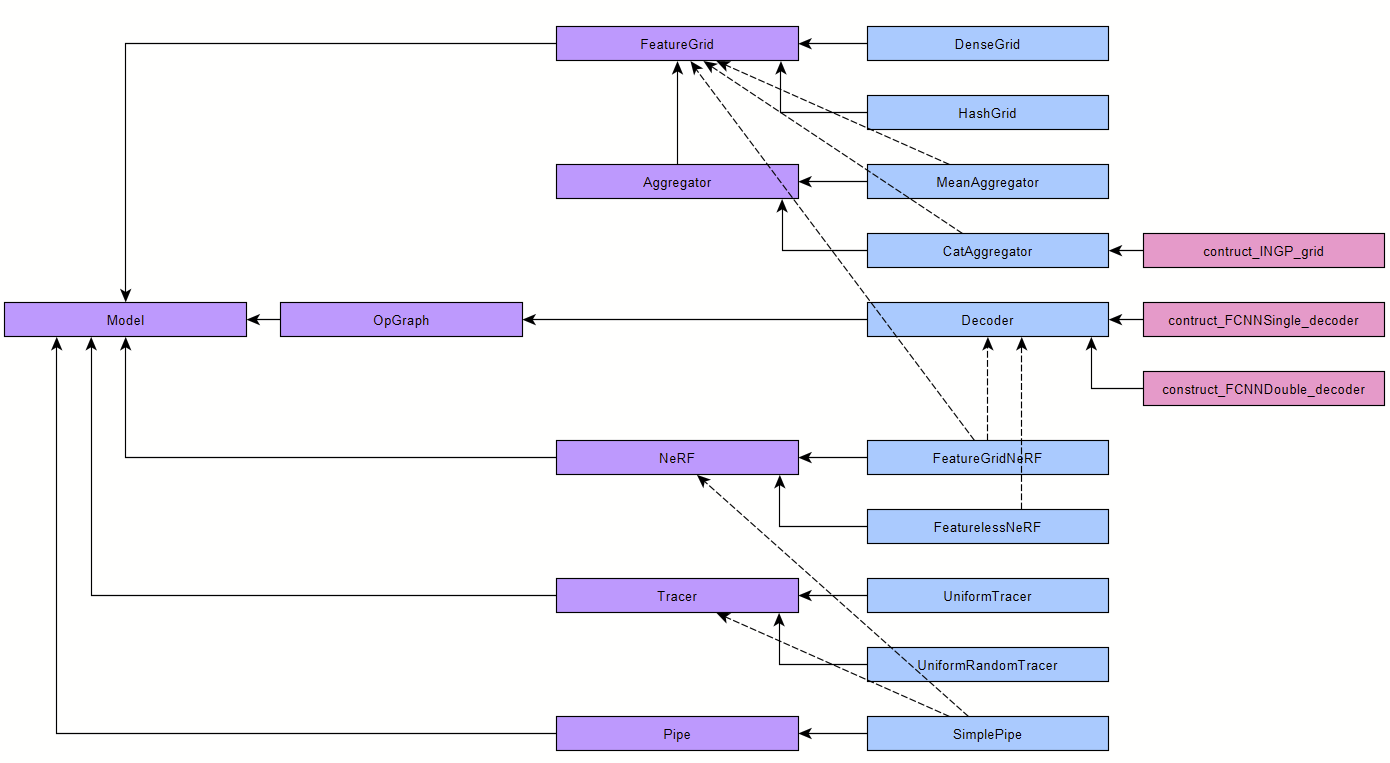

Purple boxes represent abstract classes.

Blue boxes represent instantiatable classes.

Pink boxes represent functions that construct specific objects.

Solid arrows pointing from purple/blue boxes represent inheritence.

Partial arrows pointing from blue boxes represent that an object of that class would contain an object/s of the type that the arrow is pointing to.

Solid arrows pointing from punk boxes represent what object type the function returns.

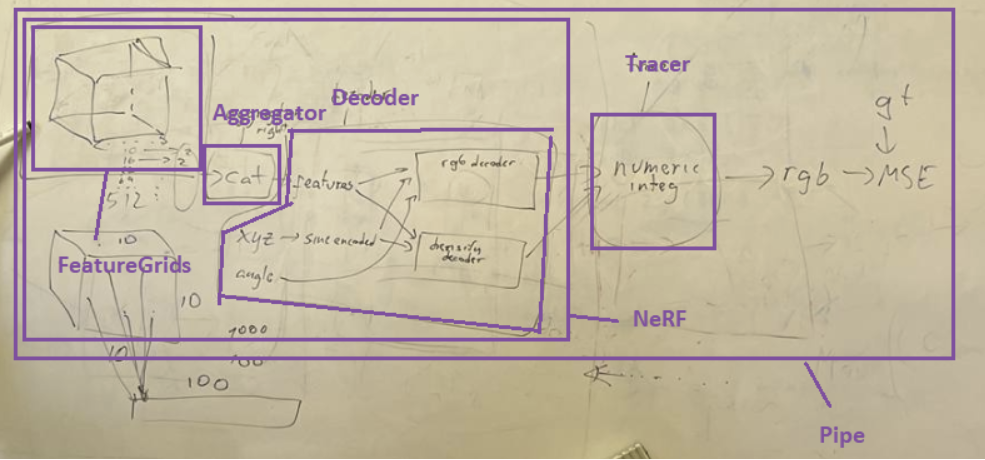

#### Short descriptions of each part
- Model
  - Represents something with (optionally)parameters and a forward function.
- Pipe
  - Represents a full pipeline that you can simply pass coordinates and view directions to, and it returns RGB values.
  - Inheriting classes:
    - SimplePipe
      - Consists of a NeRF and a Tracer.
- Tracer
  - Represents an object that does numeric integration by using a NeRF to get RGB values from NeRF's RGBσ values, given coordinates and view directions.
  - Inheriting classes:
    - UniformTracer:
      - Samples NeRF output in uniform steps along view vector.
    - UniformRandomTracer:
      - Samples NeRF output in uniform steps along view vectors, however adds random the size of a step.
- NeRF
  - Represents and object that takes coordinates and a view direction and returns RGB and density at that point.
  - Inheriting classes:
    - FeatureGridNeRF:
      - NeRF that consists of some structure that gives features and a decoder.
    - FeaturelessNeRF:
      - NeRF that simply has a decoder and no feature structure.
- OpGraph
  - Represents an object that takes in some input tensors, performs some sequence of operations on them and returns some output tensors. (I'm not sure if it was wise to create a class like this)
  - Inheriting classes:
    - Decoder
- Decoder
  - Represents an object that takes in features, coordinates and view direction, and returns RGB and density values.
  - Inheriting classes and special constructors:
    - construct_FCNNSingle_decoder:
      - Contains a single neural network that predicts both RGB and density from all inputs.
    - construct_FCNNDouble_decoder:
      - Contains two neural networks. One for RGB (that receives view direction information), and one for density (that doesn't receive direction information).
- FeatureGrid:
  - Represents an object that takes in coordinates in range [-1..1]^3 and returns feature vectors.
  - Inheriting classes:
    - DenseGrid:
      - A grid that explicitly stores feature vectors at each voxel.
    - HashGrid:
      - Same implementation as a single resolution hashtable in InstantNGP.
- Aggregator:
  - Represents an object that takes outputs of multiple feature grids and converts them into a single tensor.
  - Inheriting classes:
    - CatAggregator:
      - Concatenates features together. (This is what is used in InstantNGP)
      - Special constructor:
        - construct_INGP_grid
          - Constructs and InstantNGP-like feature grid.
    - MeanAggregator:
      - Takes the mean value of feature vectors.

### Datasets

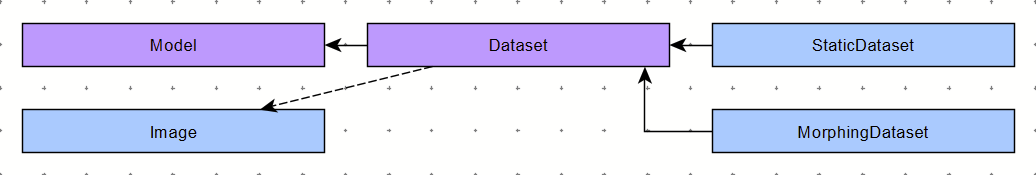

Notation used is same as in NeRF Class Structure.

An image object describes an image and it's camera parameters.

Basically there are two Dataset types:
- StaticDataset
  - Doesn't have any learnable parameters.
- MorphingDataset
  - Has learnable parameters that you set during construction.

## Getting Dataset Examples

In [ ]:
#First you get images
images = quick_colmap_images('Plant') #This function returns a list of Image objects.
#Available datasets are: 'Plant', 'Stikli', 'Blocks', 'Pillow', 'Vaze', 'Figurina'.

#Then you construct a dataset form the images
dataset = StaticDataset(images)

In [ ]:
#There's a nifty function for showing the images the dataset contains:
dataset.show_images()

In [ ]:
#There's also a nifty function for spamming all kinds of "perhaps useful" information:
dataset.spam()

Here's an example on how you'd go about getting a dataset with learnable parameters:

In [ ]:
images = quick_colmap_images('Plant', downscale = 4)
#downscale is a parameter that just downsamples the image in each direction by a factor of 4.
#This might be of use, because storing billions of floats on GPU seems to become a problem occasionally.

#Here's the full list of parameters for a MorphingDataset constructor:
dataset = MorphingDataset(images,
                         learn_radialfov = False,
                         learn_position = False,
                         learn_xfov = False,
                         learn_yfov = False,
                         learn_angle = False,
                         l2_radialfov = 1e-2,
                         l2_position = 1e-2,
                         l2_xfov = 1e-2,
                         l2_yfov = 1e-2,
                         l2_angle = 1e-2)
#In order to learn one or more of these parameters you need to simply set learn_X to True.
#If it's set to False, then the parameter is not learned.
#  All default ot False
#l2_X means L2 loss coefficient for that parameter. 
#  All default to 0.01
#
#There by default will be a pressure towards values that don't change the dataset.
#  radialfov - Whether to streatch or shrink the picture in both directions simultaneously. (common for all images)
#  position - Whether to nugde image coordinates. (different for each image)
#  xfov & yfov - Whether to stretch or shring the picture in x or y direction. (Common for all images)
#  angle - Whether to rotate the camera in 3D. (different for each image)

In [ ]:
dataset.spam()

## Training Examples

After you have your dataset, You can train as per usual:

In [ ]:
#Define pipeline
decoder = construct_FCNNdouble_decoder(feat_count = 0, 
                     encoding_levels = 14, 
                     layers = [None, 128, 128, 3], 
                     activations = [None, 'relu', 'relu', 'sigmoid'], 
                     density_layers = [None, 128, 128, 1],
                     feats = False,
                     view_vecs = True)
nerf = FeaturelessNeRF(decoder)
tracer = UniformRandomTracer(distance = 2.5, steps = 256)
pipe = SimplePipe(nerf, tracer)

#Train
train(pipe, dataset, batch_count = 2500, spam_frequency = 500, lr = 0.002)

In [ ]:
dataset.spam()

In [ ]:
#This is the full list of parameters and their defaults for the training function.
#batch_size - number of pixels per gradient step.
#lr_dataset - learning rate for dataset parameters. Note: The dataset parameters have a separate Adam optimizer.
#dataset_loss_start - batch number at which to start training learnable parameters in dataset.
"""
train(pipe, 
      dataset, 
      batch_count = 1000, 
      batch_size = 2048, 
      spam_frequency = 100, 
      lr = 0.001, 
      lr_dataset = 0.00001, 
      dataset_loss_start = 0)
"""

## Visualization Examples

In [ ]:
#Get a path along which the camera in the video will be moving.
path = get_path_from_images([images[0], images[10], images[20]], frame_count = 200)
#This function simply interpolates between the positions and rotations of a list of Image objects that you give it.
#Here I've chosen 3 images with numbers 0, 10 and 20 in the dataset.
#I've also chosen the video to have 200 frames.
#You can choose image numbers to interpolate through by looking at dataset.show_images().

In [ ]:
show_video(pipe, path, sizex = 96, sizey = 96, fovx = 1)
#Function that displays video in notebook
#sizex - pixel count in video, in x direction.
#sizey - pixel count in video, in y direction.
#The higher the fovx number, the wider the camera angle.

If you want to save a video to disk, rather than display it in the notebook:

In [ ]:
video = make_video(pipe, path, sizex = 256, sizey = 256, fovx = 1)
#This function returns a np.float32 array of shape [frame_count, sizex, sizey, rgb].
#The values are in the range [0..1].

save_video(video, 'MyVideo.mp4')
#This function saves the numpy array as an mp4 to disk.

## Some Full Examples

In [ ]:
#Get dataset
images = quick_colmap_images('Pillow', downscale = 4)
dataset = MorphingDataset(images, learn_xfov = True, learn_yfov = True)

#Make pipeline
decoder = construct_FCNNdouble_decoder(feat_count = 0, 
                     encoding_levels = 14, 
                     layers = [None, 256, 256, 3], 
                     activations = [None, 'relu', 'relu', 'sigmoid'], 
                     density_layers = [None, 256, 256, 1],
                     density_activations = [None, 'relu', 'relu', 'sigmoid'],
                     feats = False,
                     view_vecs = True)
nerf = FeaturelessNeRF(decoder)
tracer = UniformRandomTracer(distance = 2.5, steps = 384)
pipe = SimplePipe(nerf, tracer)

#Train
train(pipe, dataset, batch_count = 2500, spam_frequency = 500, lr = 0.002)

#Visualize
path = get_path_from_images([images[0], images[5], images[10], images[15]], frame_count = 500)
video = make_video(pipe, path, sizex = 128, sizey = 128, fovx = 1)
save_video(video, 'Example1.mp4')
embed_video(video) #This function shows the video in the notebook.

# Random Experiments

In [ ]:
raise Error()
#This is only here so that you could click "run all", and it wouldn't run these experiments

In [ ]:
#Define pipeline
decoder = construct_FCNNdouble_decoder(feat_count = 0, 
                     encoding_levels = 14, 
                     layers = [None, 256, 256, 3], 
                     activations = [None, 'relu', 'relu', 'sigmoid'], 
                     density_layers = [None, 256, 256, 1],
                     feats = False,
                     view_vecs = True)
nerf = FeaturelessNeRF(decoder)
tracer = UniformRandomTracer(distance = 2.5, steps = 384)
pipe = SimplePipe(nerf, tracer)

#Train
train(pipe, dataset, batch_count = 20000, spam_frequency = 1000, lr = 0.002)

In [ ]:
path = get_path_from_images([images[0], images[10], images[20], images[25]], frame_count = 1000)

vid = make_video(pipe, path, sizex = 256, sizey = 256, fovx = 1)
save_video(vid, 'plant.mp4')

In [ ]:
gc.collect()

In [ ]:
images = construct_images_from_colmap('Datasets/Figurina', 'Datasets/Figurina/Images', downscale = 2)
norm_image_coords(images)
stuff = MorphingDataset(images, learn_radialfov = True, learn_position = False, learn_xfov = True, learn_yfov = True, learn_angle = True)
decoder = construct_FCNNdouble_decoder(feat_count = 0, 
                     encoding_levels = 14, 
                     layers = [None, 256, 256, 3], 
                     activations = [None, 'relu', 'relu', 'sigmoid'], 
                     density_layers = [None, 256, 256, 1],
                     feats = False,
                     view_vecs = True)
nerf = FeaturelessNeRF(decoder)
tracer = UniformRandomTracer(distance = 2.5, steps = 256)
pipe = SimplePipe(nerf, tracer)
train(pipe, stuff, batch_count = 10000, spam_frequency = 1000, lr = 0.002)

In [ ]:
stuff.spam()

In [ ]:
path = get_path_from_images(images, frame_count = 1000)

vid = make_video(pipe, path, sizex = 256, sizey = 256, fovx = 1)
save_video(vid, 'test.mp4')

In [ ]:
path = get_path_from_images(images[25:], frame_count = 200)

show_video(pipe, path, sizex = 128, sizey = 128, fovx = 1)

In [ ]:
gc.collect()

In [ ]:
halt

In [ ]:
path = get_path_from_images(images, frame_count = 1000)

vid = make_video(pipe, path, sizex = 256, sizey = 256, fovx = 1)
save_video(vid, 'test.mp4')

In [ ]:
stuff.show_images()

In [ ]:
stuff.spam()

In [ ]:
stuff = None
gc.collect()
stuff = construct_images_from_colmap('Datasets/Stikli', 'Datasets/Stikli/Images')
stuff = MorphingDataset(stuff, learn_radialfov = False, learn_position = False, learn_xfov = False, learn_yfov = False)

In [ ]:
decoder = construct_FCNNdouble_decoder(feat_count = 0, 
                     encoding_levels = 14, 
                     layers = [None, 256, 256, 3], 
                     activations = [None, 'relu', 'relu', 'sigmoid'], 
                     density_layers = [None, 256, 256, 1],
                     feats = False,
                     view_vecs = True)
nerf = FeaturelessNeRF(decoder)
tracer = UniformRandomTracer(distance = 2.5, steps = 256)
pipe = SimplePipe(nerf, tracer)
train(pipe, stuff, batch_count = 10000, spam_frequency = 1000, lr = 0.002)

In [ ]:
show_video(pipe, VIDEOPATH_XZCIRCLE.downsample(6) / 3 + [-0.1, 0.25, 0.4], sizex = 128, sizey = 128, fovx = 1.5)

In [ ]:
stuff.spam()

In [ ]:
stuff = None
gc.collect()
stuff = construct_images_from_colmap('Datasets/Stikli', 'Datasets/Stikli/Images')
stuff = MorphingDataset(stuff, learn_radialfov = True, learn_position = False, learn_xfov = False, learn_yfov = False)

In [ ]:
decoder = construct_FCNNdouble_decoder(feat_count = 0, 
                     encoding_levels = 14, 
                     layers = [None, 256, 256, 3], 
                     activations = [None, 'relu', 'relu', 'sigmoid'], 
                     density_layers = [None, 256, 256, 1],
                     feats = False,
                     view_vecs = True)
nerf = FeaturelessNeRF(decoder)
tracer = UniformRandomTracer(distance = 2.5, steps = 256)
pipe = SimplePipe(nerf, tracer)
train(pipe, stuff, batch_count = 10000, spam_frequency = 1000, lr = 0.002)

In [ ]:
show_video(pipe, VIDEOPATH_XZCIRCLE.downsample(6) / 3 + [-0.1, 0.25, 0.4], sizex = 128, sizey = 128, fovx = 1.5)

In [ ]:
stuff.spam()

In [ ]:
import gc
gc.collect()

In [ ]:
stuff.show_images()

In [ ]:
stuff = construct_colmap_dataset('Datasets/Stikli', 'Datasets/Stikli/Images')
stuff = StaticDataset(stuff[0], stuff[1], stuff[2])
stuff.show_images()

In [ ]:
decoder = construct_FCNNsingle_decoder(feat_count = 0, 
                     encoding_levels = 14, 
                     layers = [None, 256, 256, 4], 
                     activations = [None, 'relu', 'relu', 'sigmoid'], 
                     feats = False,
                     view_vecs = True)
nerf = FeaturelessNeRF(decoder)
tracer = UniformRandomTracer(distance = 2.5, steps = 256)
pipe = SimplePipe(nerf, tracer)
train(pipe, stuff, batch_count = 10000, spam_frequency = 1000, lr = 0.002)

In [ ]:
show_video(pipe, VIDEOPATH_XZCIRCLE.downsample(6) / 3 + [-0.1, 0.25, 0.4], sizex = 96, sizey = 96, fovx = 1.5)

## Delay Learning Dataset Experiment 

In [ ]:
stuff = None
gc.collect()
stuff = construct_images_from_colmap('Datasets/Stikli', 'Datasets/Stikli/Images')
stuff = MorphingDataset(stuff, learn_radialfov = True, learn_position = False, learn_xfov = False, learn_yfov = False)

### With offset

In [ ]:
decoder = construct_FCNNdouble_decoder(feat_count = 0, 
                     encoding_levels = 14, 
                     layers = [None, 256, 256, 3], 
                     activations = [None, 'relu', 'relu', 'sigmoid'], 
                     density_layers = [None, 256, 256, 1],
                     feats = False,
                     view_vecs = True)
nerf = FeaturelessNeRF(decoder)
tracer = UniformRandomTracer(distance = 2.5, steps = 256)
pipe = SimplePipe(nerf, tracer)
train(pipe, stuff, batch_count = 10000, spam_frequency = 1000, lr = 0.002, dataset_loss_start = 5000)
show_video(pipe, VIDEOPATH_XZCIRCLE.downsample(6) / 3 + [-0.1, 0.25, 0.4], sizex = 128, sizey = 128, fovx = 1.5)

In [ ]:
stuff.spam()

### No learning

In [ ]:
stuff = None
gc.collect()
stuff = construct_images_from_colmap('Datasets/Stikli', 'Datasets/Stikli/Images')
stuff = StaticDataset(stuff)

In [ ]:
decoder = construct_FCNNdouble_decoder(feat_count = 0, 
                     encoding_levels = 14, 
                     layers = [None, 256, 256, 3], 
                     activations = [None, 'relu', 'relu', 'sigmoid'], 
                     density_layers = [None, 256, 256, 1],
                     feats = False,
                     view_vecs = True)
nerf = FeaturelessNeRF(decoder)
tracer = UniformRandomTracer(distance = 2.5, steps = 256)
pipe = SimplePipe(nerf, tracer)
train(pipe, stuff, batch_count = 10000, spam_frequency = 1000, lr = 0.002, dataset_loss_start = 100000)
show_video(pipe, VIDEOPATH_XZCIRCLE.downsample(6) / 3 + [-0.1, 0.25, 0.4], sizex = 128, sizey = 128, fovx = 1.5)

In [ ]:
stuff.spam()

### Everything

In [ ]:
pipe = None
stuff = None
gc.collect()

In [ ]:
stuff = None
gc.collect()
stuff = construct_images_from_colmap('Datasets/Stikli', 'Datasets/Stikli/Images')
stuff = MorphingDataset(stuff, learn_radialfov = True, learn_position = True, learn_xfov = True, learn_yfov = True)

In [ ]:
decoder = construct_FCNNdouble_decoder(feat_count = 0, 
                     encoding_levels = 14, 
                     layers = [None, 256, 256, 3], 
                     activations = [None, 'relu', 'relu', 'sigmoid'], 
                     density_layers = [None, 256, 256, 1],
                     feats = False,
                     view_vecs = True)
nerf = FeaturelessNeRF(decoder)
tracer = UniformRandomTracer(distance = 2.5, steps = 256)
pipe = SimplePipe(nerf, tracer)
train(pipe, stuff, batch_count = 10000, spam_frequency = 1000, lr = 0.002, dataset_loss_start = 5000, lr_dataset = 3e-4)
show_video(pipe, VIDEOPATH_XZCIRCLE.downsample(6) / 3 + [-0.1, 0.25, 0.4], sizex = 128, sizey = 128, fovx = 1.5)

In [ ]:
stuff.spam()